# Import Library

In [3]:
!pip install kneed

In [4]:
# from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from kneed import KneeLocator
from sklearn.decomposition import PCA
import plotly.express as px
import os

ModuleNotFoundError: No module named 'plotly'

In [ ]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bhavikjikadara/retail-transactional-dataset
!unzip retail-transactional-dataset.zip
!ls

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/retail-transactional-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
retail-transactional-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  retail-transactional-dataset.zip
replace retail_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: retail_data.csv         
'kaggle (1).json'   kaggle.json       retail-transactional-dataset.zip
'kaggle (2).json'   retail_data.csv   sample_data


# Data Understanding

## Load dataset, pilih kolom, rename kolom dan ubah menjadi lowercase

In [ ]:
df = pd.read_csv('retail_data.csv')
selected_columns = [
    'Customer_ID', 'Transaction_ID', 'Date', 'Order_Status', 'Age',
    'Gender', 'Income', 'Product_Category', 'products', 'Payment_Method',
    'Total_Purchases', 'Amount', 'Total_Amount'
]
df = df[selected_columns].copy()
df = df.rename(columns={
    'Total_Purchases': 'quantity',
    'Amount': 'unit_price',
    'Total_Amount': 'subtotal'
})
df.columns = df.columns.str.lower()
df.head()

,customer_id,transaction_id,date,order_status,age,gender,income,product_category,products,payment_method,quantity,unit_price,subtotal
0,37249.0,8691788.0,9/18/2023,Shipped,21.0,Male,Low,Clothing,Cycling shorts,Debit Card,3.0,108.028757,324.086270
1,69749.0,2174773.0,12/31/2023,Processing,19.0,Female,Low,Electronics,Lenovo Tab,Credit Card,2.0,403.353907,806.707815
2,30192.0,6679610.0,4/26/2023,Processing,48.0,Male,Low,Books,Sports equipment,Credit Card,3.0,354.477600,1063.432799
3,62101.0,7232460.0,05-08-23,Processing,56.0,Male,High,Home Decor,Utility knife,PayPal,7.0,352.407717,2466.854021
4,27901.0,4983775.0,01-10-24,Shipped,22.0,Male,Low,Grocery,Chocolate cookies,Cash,2.0,124.276524,248.553049


In [ ]:
df.shape

(302010, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302010 entries, 0 to 302009
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_id       301702 non-null  float64
 1   transaction_id    301677 non-null  float64
 2   date              301651 non-null  object 
 3   order_status      301775 non-null  object 
 4   age               301837 non-null  float64
 5   gender            301693 non-null  object 
 6   income            301720 non-null  object 
 7   product_category  301727 non-null  object 
 8   products          302010 non-null  object 
 9   payment_method    301713 non-null  object 
 10  quantity          301649 non-null  float64
 11  unit_price        301653 non-null  float64
 12  subtotal          301660 non-null  float64
dtypes: float64(6), object(7)
memory usage: 30.0+ MB


In [ ]:
df.describe()

,customer_id,transaction_id,age,quantity,unit_price,subtotal
count,301702.000000,3.016770e+05,301837.000000,301649.000000,301653.000000,301660.000000
mean,55006.553934,5.495823e+06,35.481326,5.359729,255.163659,1367.651156
std,26005.675200,2.595565e+06,15.021933,2.868575,141.389640,1128.998515
min,10000.000000,1.000007e+06,18.000000,1.000000,10.000219,10.003750
25%,32469.250000,3.247930e+06,22.000000,3.000000,132.890764,438.724278
50%,55012.000000,5.499657e+06,32.000000,5.000000,255.470969,1041.117547
75%,77511.000000,7.739509e+06,46.000000,8.000000,377.672606,2029.999853
max,99999.000000,9.999995e+06,70.000000,10.000000,499.997911,4999.625796


In [ ]:
df.isna().sum()

,0
customer_id,308
transaction_id,333
date,359
order_status,235
age,173
gender,317
income,290
product_category,283
products,0
payment_method,297


In [ ]:
df.duplicated().sum()

np.int64(25)

## Outlier

In [ ]:
num_cols = ['age', 'quantity', 'unit_price', 'subtotal']
cat_cols = ['order_status', 'gender', 'income', 'product_category', 'products', 'payment_method']

# Ambang batas z-score (biasanya 3)
threshold = 3

# Hitung Z-score hanya untuk kolom numerik
z_scores = np.abs(stats.zscore(df[num_cols]))

# Buat mask/filter dimana z_score > 3
outliers_mask = (z_scores > threshold)

# Hitung jumlah outlier per kolom
outlier_counts = pd.DataFrame(outliers_mask, columns=num_cols).sum()
print(f"Jumlah Outlier terdeteksi (Threshold > {threshold}):")
print(outlier_counts)

Jumlah Outlier terdeteksi (Threshold > 3):
age           0
quantity      0
unit_price    0
subtotal      0
dtype: int64


## Konversi format tanggal biar seragam

In [ ]:
df['date'] = pd.to_datetime(df['date'], dayfirst=False, errors='coerce')

# Cek apakah ada data tanggal yang gagal dikonversi (NaT)
invalid_dates = df['date'].isna().sum()
if invalid_dates > 0:
    print(f"Peringatan: Ada {invalid_dates} baris dengan format tanggal yang salah dan telah dihapus.")
    df.dropna(subset=['date'], inplace=True)
else:
    print("Semua tanggal berhasil dikonversi dengan sukses.")

print(f"\nTipe data kolom Date sekarang: {df['date'].dtype}")
print(df['date'].head(10))

Peringatan: Ada 119115 baris dengan format tanggal yang salah dan telah dihapus.

Tipe data kolom Date sekarang: datetime64[ns]
0    2023-09-18
1    2023-12-31
2    2023-04-26
5    2023-09-21
6    2023-06-26
7    2023-03-24
10   2023-07-20
11   2023-06-21
14   2023-11-18
15   2023-06-15
Name: date, dtype: datetime64[ns]


# EDA

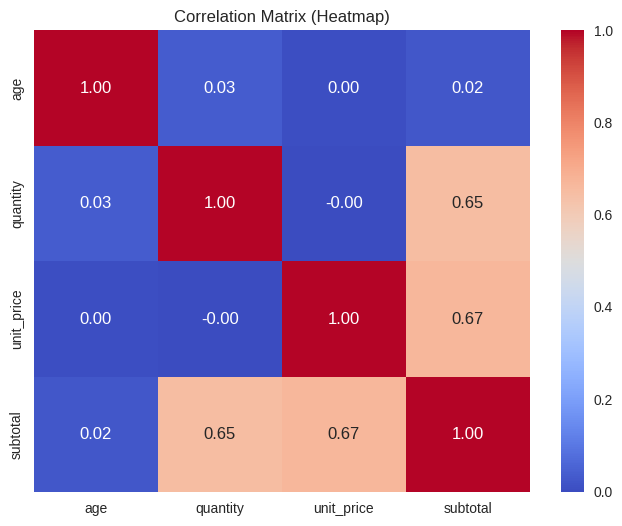

In [ ]:
plt.figure(figsize=(8, 6))
valid_cols = [c for c in num_cols if c in df.columns]
sns.heatmap(df[valid_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Heatmap)')
plt.show()

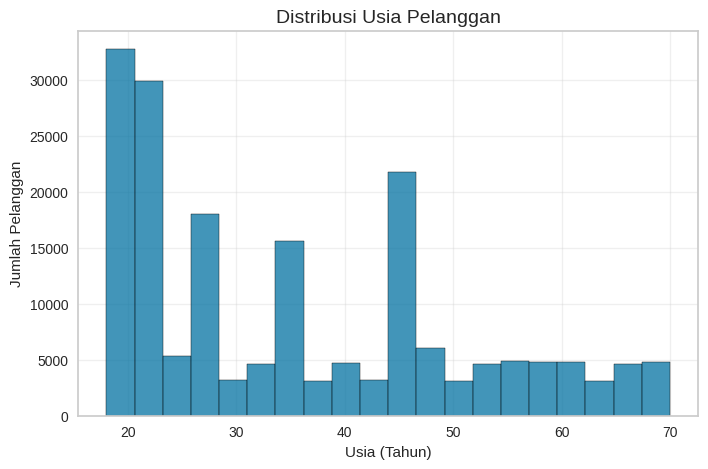

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['age'], bins=20)
plt.title('Distribusi Usia Pelanggan', fontsize=14)
plt.xlabel('Usia (Tahun)')
plt.ylabel('Jumlah Pelanggan')
plt.grid(alpha=0.3)
plt.show()

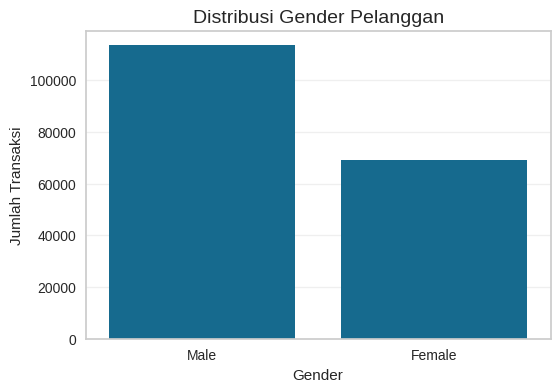

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df)
plt.title('Distribusi Gender Pelanggan', fontsize=14)
plt.xlabel('Gender')
plt.ylabel('Jumlah Transaksi')
plt.grid(axis='y', alpha=0.3)
plt.show()

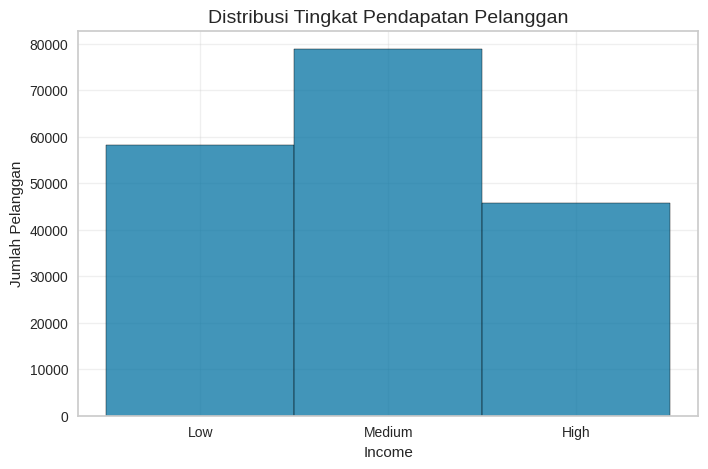

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['income'], bins=25)
plt.title('Distribusi Tingkat Pendapatan Pelanggan', fontsize=14)
plt.xlabel('Income')
plt.ylabel('Jumlah Pelanggan')
plt.grid(alpha=0.3)
plt.show()

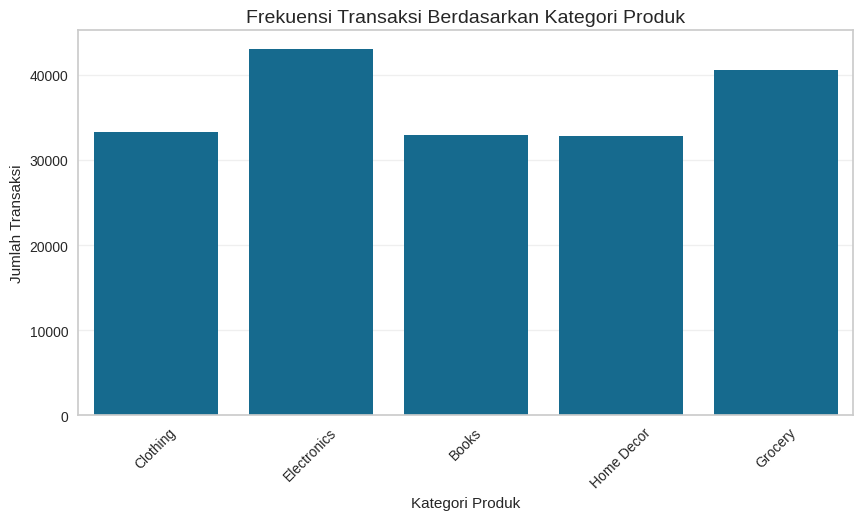

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='product_category', data=df)
plt.title('Frekuensi Transaksi Berdasarkan Kategori Produk', fontsize=14)
plt.xlabel('Kategori Produk')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

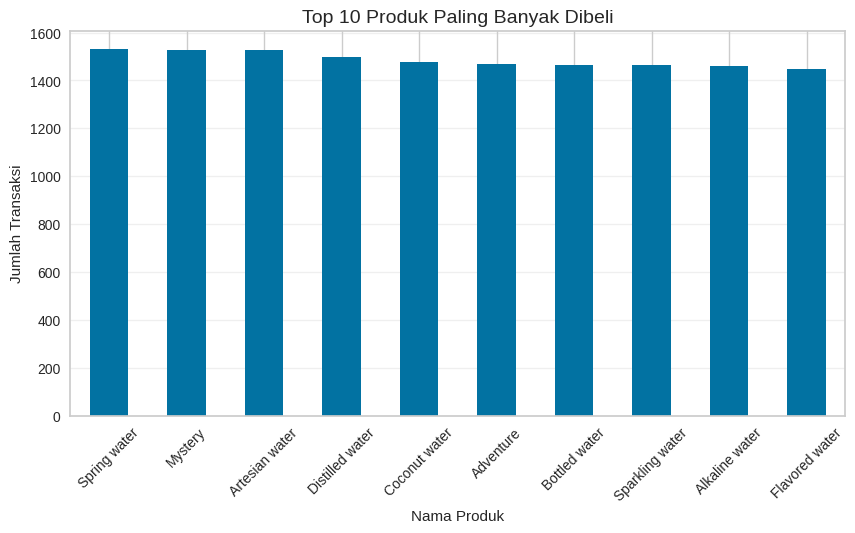

In [ ]:
plt.figure(figsize=(10,5))
df['products'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Produk Paling Banyak Dibeli', fontsize=14)
plt.xlabel('Nama Produk')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

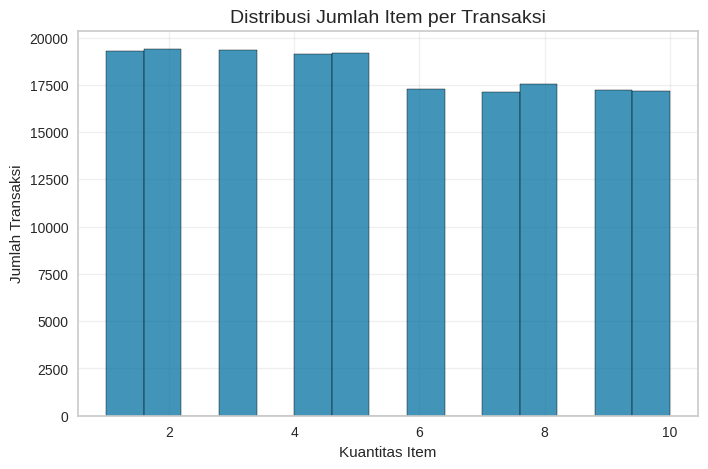

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['quantity'], bins=15)
plt.title('Distribusi Jumlah Item per Transaksi', fontsize=14)
plt.xlabel('Kuantitas Item')
plt.ylabel('Jumlah Transaksi')
plt.grid(alpha=0.3)
plt.show()

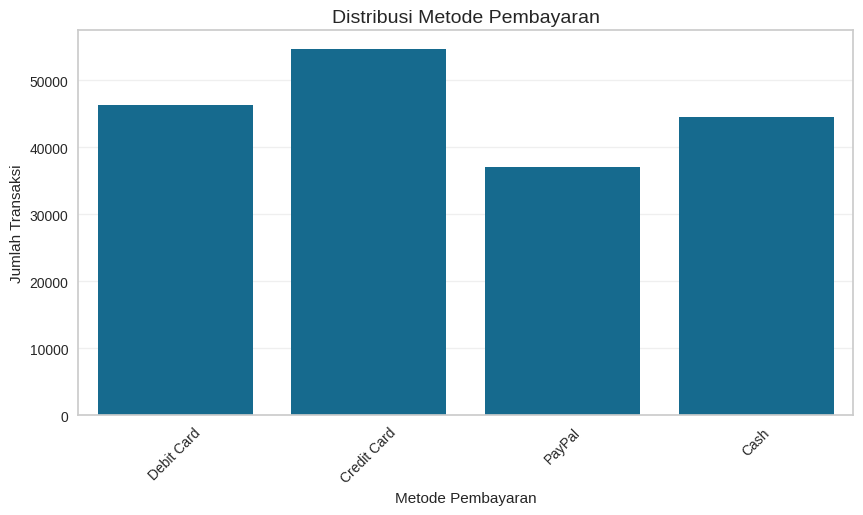

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='payment_method', data=df)
plt.title('Distribusi Metode Pembayaran', fontsize=14)
plt.xlabel('Metode Pembayaran')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

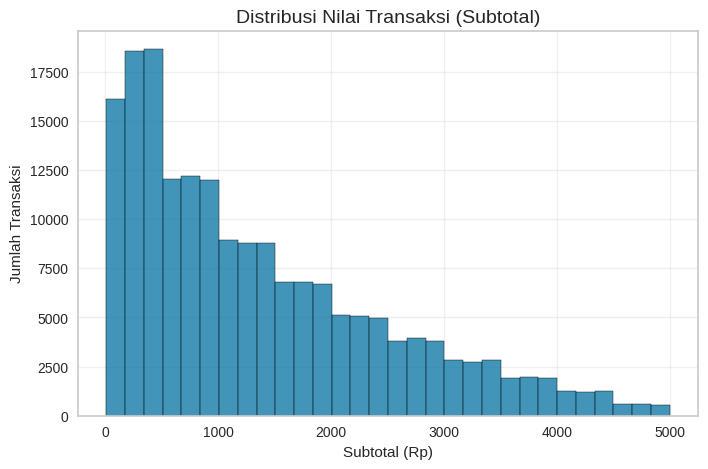

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['subtotal'], bins=30)
plt.title('Distribusi Nilai Transaksi (Subtotal)', fontsize=14)
plt.xlabel('Subtotal (Rp)')
plt.ylabel('Jumlah Transaksi')
plt.grid(alpha=0.3)
plt.show()

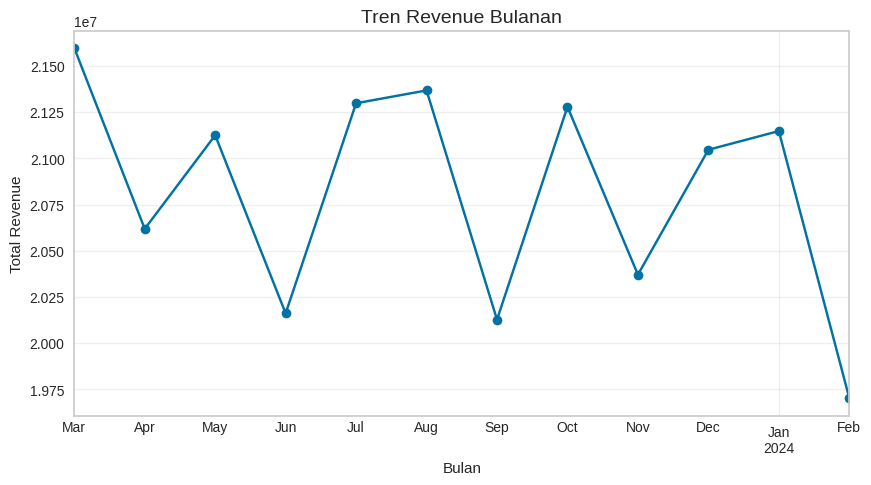

In [ ]:
# Pastikan Date sudah datetime
df['Month'] = df['date'].dt.to_period('M')

monthly_revenue = df.groupby('Month')['subtotal'].sum()

plt.figure(figsize=(10,5))
monthly_revenue.plot(kind='line', marker='o')
plt.title('Tren Revenue Bulanan', fontsize=14)
plt.xlabel('Bulan')
plt.ylabel('Total Revenue')
plt.grid(alpha=0.3)
# plt.xticks(rotation=45)
plt.show()

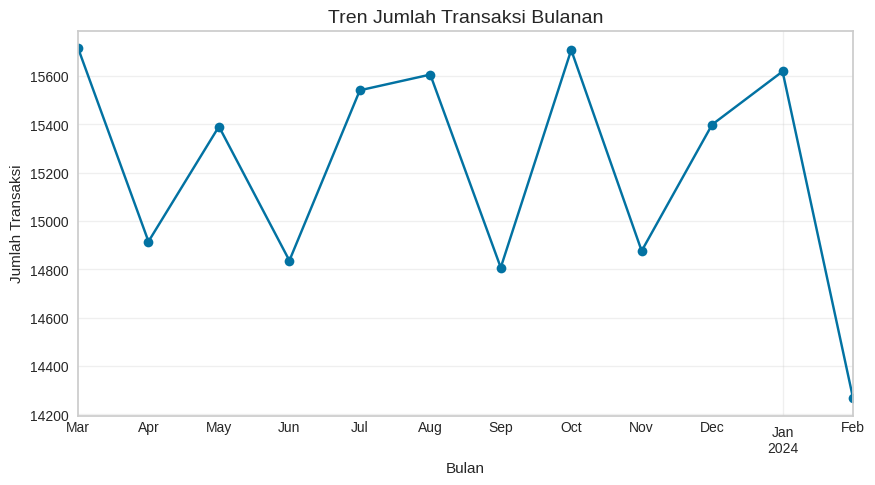

In [ ]:
monthly_transactions = df.groupby('Month')['transaction_id'].count()

plt.figure(figsize=(10,5))
monthly_transactions.plot(kind='line', marker='o')
plt.title('Tren Jumlah Transaksi Bulanan', fontsize=14)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Transaksi')
plt.grid(alpha=0.3)
# plt.xticks(rotation=45)
plt.show()

# Data Preprocessing

## Ambil baris data yang memiliki status delivered atau shipped

In [ ]:
status_layak = ['Delivered', 'Shipped']
df = df[df['order_status'].isin(status_layak)]
print(df['order_status'].head(10))

0       Shipped
10      Shipped
14      Shipped
17      Shipped
19      Shipped
28    Delivered
44    Delivered
48    Delivered
52    Delivered
54      Shipped
Name: order_status, dtype: object


In [ ]:
df = df.dropna()

In [ ]:
df = df.drop_duplicates()

## Pisah kolom yang relevan untuk RFM menjadi dataframe tersendiri

In [ ]:
df = df.drop(columns=['Month'])
df_rfm = df[['customer_id', 'date', 'transaction_id', 'subtotal']].copy()

temp_columns = [col for col in df.columns if col not in ['customer_id', 'date', 'transaction_id', 'subtotal']]
df_temp = df[temp_columns].copy()

print("RFM DataFrame columns:", df_rfm.columns.tolist())
print("Temporary DataFrame columns:", df_temp.columns.tolist())

RFM DataFrame columns: ['customer_id', 'date', 'transaction_id', 'subtotal']
Temporary DataFrame columns: ['order_status', 'age', 'gender', 'income', 'product_category', 'products', 'payment_method', 'quantity', 'unit_price']


## Perhitungan RFM

In [ ]:
snapshot_date = df['date'].max() + pd.Timedelta(days=1)

print(f"Tanggal Snapshot (Referensi): {snapshot_date}")

# Hitung R, F, M per Customer
df_rfm = df_rfm.groupby('customer_id').agg({
    'date': lambda x: (snapshot_date - x.max()).days, # Recency: Jarak hari dari pembelian terakhir
    'transaction_id': 'nunique',                         # Frequency: Jumlah kali transaksi
    'subtotal': 'sum'                                # Monetary: Total uang yang dibelanjakan
})

df_rfm.rename(columns={
    'date': 'Recency',
    'transaction_id': 'Frequency',
    'subtotal': 'Monetary'
}, inplace=True)

print("Sample Tabel RFM")
display(df_rfm.head())

Tanggal Snapshot (Referensi): 2024-03-01 00:00:00
Sample Tabel RFM


,Recency,Frequency,Monetary
customer_id,,,
10000.0,103,3,2324.509346
10001.0,105,4,4256.918342
10002.0,95,4,3747.140929
10003.0,228,1,1890.735874
10005.0,246,1,3073.147975


## Cek distribusi data tiap kolom

In [ ]:
print(df_rfm.skew())

Recency      0.452931
Frequency    1.345796
Monetary     1.333794
dtype: float64


In [ ]:
# 1. Inisialisasi PowerTransformer
# standardize=True artinya dia sekalian melakukan Scaling (Z-Score)
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# 2. Fit & Transform data RFM asli (bukan yang sudah di-log)
rfm_transformed = pt.fit_transform(df_rfm)

# 3. Kembalikan ke DataFrame
rfm_scaled_df = pd.DataFrame(rfm_transformed, index=df_rfm.index, columns=df_rfm.columns)

print("--- Skewness Setelah Yeo-Johnson Transformation ---")
print(rfm_scaled_df.skew())

print("\n--- Sample Data Akhir ---")
display(rfm_scaled_df.head())

--- Skewness Setelah Yeo-Johnson Transformation ---
Recency     -0.203351
Frequency    0.231643
Monetary    -0.071731
dtype: float64

--- Sample Data Akhir ---


,Recency,Frequency,Monetary
customer_id,,,
10000.0,-0.130072,1.303840,0.219217
10001.0,-0.109449,1.669786,0.984074
10002.0,-0.214703,1.669786,0.809740
10003.0,0.904203,-0.980469,-0.008470
10005.0,1.025502,-0.980469,0.553036


# Modelling

## K-means

Sedang menghitung inertia untuk k=1 sampai 14...

Jumlah cluster optimal (best_k) ditemukan: 4


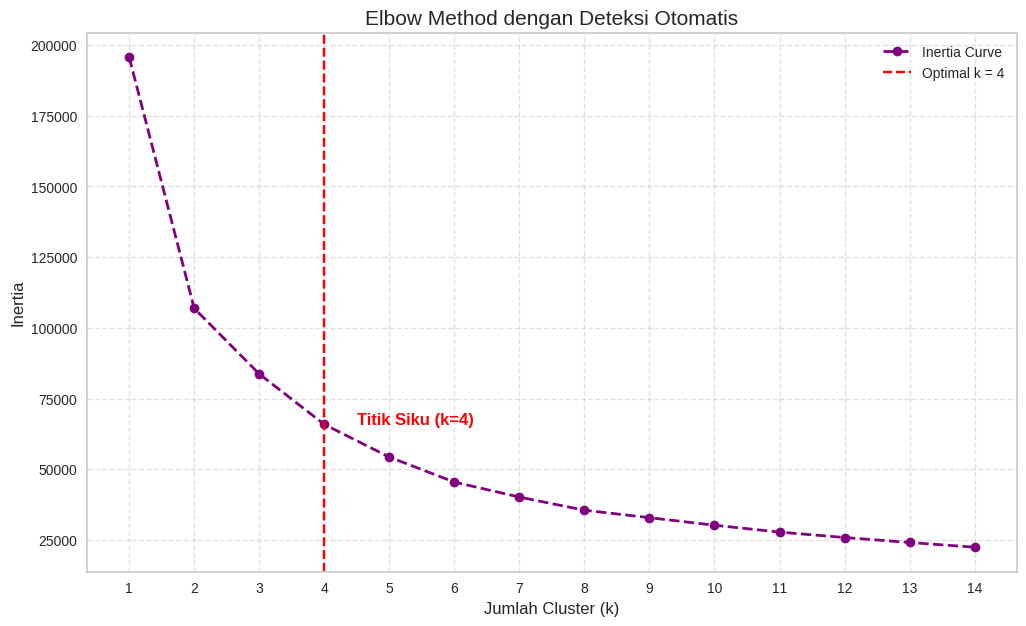

In [ ]:
# --- 1. PERHITUNGAN (WAJIB ADA) ---
# Ini adalah kode lama Anda. Kita butuh ini untuk menghitung Inertia.
inertia = []
k_range = range(1, 15) # Menggunakan range 1-15 sesuai kode terakhir Anda

print("Sedang menghitung inertia untuk k=1 sampai 14...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

# --- 2. DETEKSI OTOMATIS (BARU) ---
# Ini fitur tambahan agar python yang menentukan angkanya, bukan mata kita.
kl = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
best_k = kl.elbow

print(f"\nJumlah cluster optimal (best_k) ditemukan: {best_k}")

# --- 3. VISUALISASI UPGRADED ---
# Ini menggantikan plt.plot biasa dengan versi yang ada garis merahnya
plt.figure(figsize=(12, 7))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='purple', linewidth=2, label='Inertia Curve')

# Tambahkan garis vertikal di titik optimal
if best_k:
    plt.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal k = {best_k}')
    plt.text(best_k + 0.5, inertia[k_range.index(best_k)], f'Titik Siku (k={best_k})',
             color='red', fontweight='bold', fontsize=12)

plt.title('Elbow Method dengan Deteksi Otomatis', fontsize=15)
plt.xlabel('Jumlah Cluster (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Simpan k optimal ke variabel global agar bisa dipakai di tahap selanjutnya
optimal_k_clusters = best_k

## k cluster sesuai jumlah segment

In [ ]:
k_business = 5
kmeans_final = KMeans(n_clusters=k_business, random_state=42, n_init=10)

# 2. Fit model ke data yang sudah discaling (rfm_scaled_df)
kmeans_final.fit(rfm_scaled_df)

# 3. Masukkan label cluster ke DataFrame asli (agar bisa dibaca manusia)
# Penting: Kita masukkan ke 'rfm' (data asli), bukan 'rfm_scaled_df' (data hasil transformasi)
df_rfm['Cluster'] = kmeans_final.labels_

# --- INTERPRETASI PROFIL CLUSTER ---
# Kita hitung rata-rata R, F, M untuk setiap cluster
cluster_summary = df_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count' # Untuk melihat jumlah member per cluster
}).rename(columns={'Cluster': 'Count'})

# Tampilkan hasil
print(f"Model terbentuk dengan {k_business} cluster!")
print("\n--- Profil Rata-rata Setiap Cluster ---")
display(cluster_summary.sort_values(by='Monetary', ascending=False))

Model terbentuk dengan 5 cluster!

--- Profil Rata-rata Setiap Cluster ---


,Recency,Frequency,Monetary,Count
Cluster,,,,
2,40.607774,2.874975,4442.761847,15101
0,166.371898,2.282310,2938.446593,16241
4,225.747378,1.000000,2342.640408,11729
3,44.502700,1.171198,1202.518891,10555
1,228.293144,1.029495,462.776640,11595


## k cluster sesuai grafik

In [ ]:
# kmeans_final = KMeans(n_clusters=optimal_k_clusters, random_state=42, n_init=10)

# # 2. Fit model ke data yang sudah discaling (rfm_scaled_df)
# kmeans_final.fit(rfm_scaled_df)

# # 3. Masukkan label cluster ke DataFrame asli (agar bisa dibaca manusia)
# # Penting: Kita masukkan ke 'rfm' (data asli), bukan 'rfm_scaled_df' (data hasil transformasi)
# df_rfm['Cluster'] = kmeans_final.labels_

# # --- INTERPRETASI PROFIL CLUSTER ---
# # Kita hitung rata-rata R, F, M untuk setiap cluster
# cluster_summary = df_rfm.groupby('Cluster').agg({
#     'Recency': 'mean',
#     'Frequency': 'mean',
#     'Monetary': 'mean',
#     'Cluster': 'count' # Untuk melihat jumlah member per cluster
# }).rename(columns={'Cluster': 'Count'})

# # Tampilkan hasil
# print(f"Model terbentuk dengan {optimal_k_clusters} cluster!")
# print("\n--- Profil Rata-rata Setiap Cluster ---")
# display(cluster_summary.sort_values(by='Monetary', ascending=False))

## Kasih nama segment

In [ ]:
# Mapping 5 Cluster sesuai analisis di atas
segment_map_5 = {
    2: 'Loyalists',      # R:Low, F:High, M:High (Terbaik)
    0: 'At Risk',        # R:High, F:High, M:High (Mantan Loyal)
    3: 'New Customers',  # R:Low, F:Low, M:Low   (Baru Masuk)
    1: 'Hibernating',    # R:High, F:Low, M:Low  (Lama Hilang & Kecil)
    4: 'Big Spenders'    # R:High, F:Low, M:High (Sekali Beli tapi Mahal)
}

# Terapkan ke DataFrame
df_rfm['Customer_Segment'] = df_rfm['Cluster'].map(segment_map_5)

# Tampilkan Hasil Akhir untuk Verifikasi
print("--- Hasil Segmentasi dengan 5 Label ---")
display(df_rfm[['Recency', 'Frequency', 'Monetary', 'Customer_Segment']].sample(10))

--- Hasil Segmentasi dengan 5 Label ---


,Recency,Frequency,Monetary,Customer_Segment
customer_id,,,,
46975.0,100,4,7096.205958,Loyalists
92092.0,226,1,411.576152,Hibernating
63914.0,250,2,1559.106128,At Risk
30979.0,4,1,475.935569,New Customers
50090.0,75,2,4539.822856,Loyalists
18082.0,135,2,514.357381,At Risk
44808.0,195,1,1749.198221,Big Spenders
65488.0,130,1,1385.720816,Big Spenders
88974.0,191,1,261.373274,Hibernating


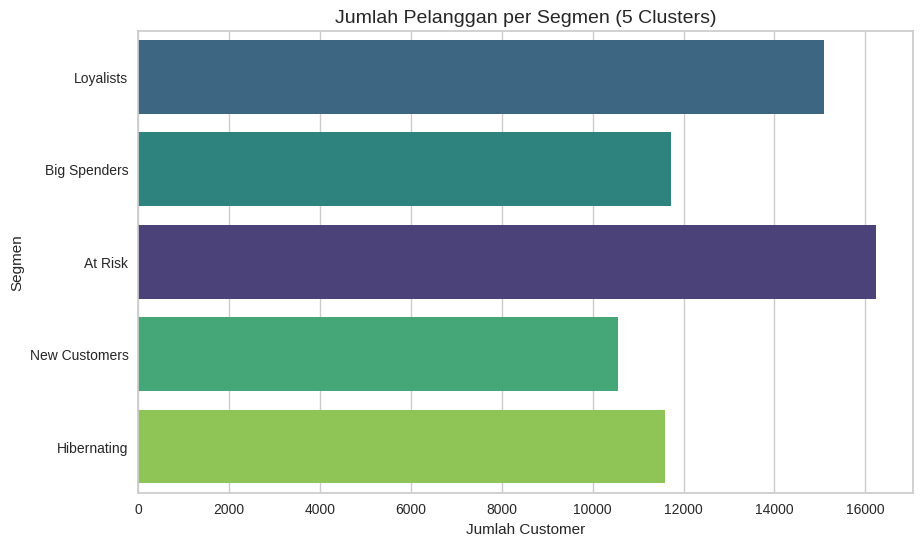

In [ ]:
plt.figure(figsize=(10, 6))
# Mengurutkan agar warnanya konsisten
order_list = ['Loyalists', 'Big Spenders', 'At Risk', 'New Customers', 'Hibernating']
sns.countplot(y='Customer_Segment', hue='Customer_Segment', data=df_rfm, order=order_list, palette='viridis')
plt.title('Jumlah Pelanggan per Segmen (5 Clusters)', fontsize=14)
plt.xlabel('Jumlah Customer')
plt.ylabel('Segmen')
plt.show()

# Evaluation

## Skor silhoutte

In [ ]:
# --- 1. HITUNG SKOR RATA-RATA ---
# Kita gunakan data yang sudah di-scaling (rfm_scaled_df) karena K-Means bekerja berdasarkan jarak
score = silhouette_score(rfm_scaled_df, kmeans.labels_)

print(f"Silhouette Score untuk k=5 adalah: {score:.3f}")

# --- INTERPRETASI SINGKAT ---
if score > 0.5:
    print("Kualitas Cluster: SANGAT KUAT (Struktur terpisah jelas)")
elif score > 0.25:
    print("Kualitas Cluster: CUKUP (Struktur terlihat, tapi ada overlap wajar)")
else:
    print("Kualitas Cluster: LEMAH (Data mungkin terlalu menyatu/homogen)")


Silhouette Score untuk k=5 adalah: 0.311
Kualitas Cluster: CUKUP (Struktur terlihat, tapi ada overlap wajar)


## Versi strict, hapus lebih bnyk outlier

In [ ]:
Q1 = rfm_scaled_df.quantile(0.05)
Q3 = rfm_scaled_df.quantile(0.95)
IQR = Q3 - Q1

# Filter data
rfm_clean = rfm_scaled_df[~((rfm_scaled_df < (Q1 - 1.5 * IQR)) | (rfm_scaled_df > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Ukuran data awal: {rfm_scaled_df.shape}")
print(f"Ukuran data setelah strict cleaning: {rfm_clean.shape}")

# Re-Run K-Means pada data yang lebih bersih
kmeans_clean = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_clean = kmeans_clean.fit_predict(rfm_clean)

score_clean = silhouette_score(rfm_clean, labels_clean)
print(f"\nSilhouette Score setelah Outlier Removal: {score_clean:.3f}")

Ukuran data awal: (65221, 3)
Ukuran data setelah strict cleaning: (65221, 3)

Silhouette Score setelah Outlier Removal: 0.332


In [ ]:
sample_silhouette_values = silhouette_samples(rfm_scaled_df, kmeans.labels_)

# 2. Masukkan skor ini ke dalam DataFrame asli untuk dianalisis
# Kita buat copy agar tidak mengganggu data utama jika ingin eksperimen
df_eval = df_rfm.copy()
df_eval['Silhouette_Score'] = sample_silhouette_values

# 3. Hitung Rata-rata Skor per Segmen
cluster_silhouette_scores = df_eval.groupby('Customer_Segment')['Silhouette_Score'].mean().sort_values(ascending=False)

print("--- Rata-rata Silhouette Score per Cluster ---")
print(cluster_silhouette_scores)

--- Rata-rata Silhouette Score per Cluster ---
Customer_Segment
Big Spenders     0.353866
Hibernating      0.352242
New Customers    0.340111
At Risk          0.289222
Loyalists        0.248051
Name: Silhouette_Score, dtype: float64


## Buat visualisasi PCA

Sedang melakukan reduksi dimensi dengan PCA...

--- Sample Data setelah PCA (Siap Visualisasi) ---


,PC1 (Principal Component 1),PC2 (Principal Component 2),Customer_Segment
0,1.040306,0.214545,At Risk
1,1.731307,0.656822,Loyalists
2,1.674287,0.483393,Loyalists
3,-1.058516,0.609561,Big Spenders
4,-0.774759,0.979994,Big Spenders



Explained Variance Ratio per Komponen: [0.60987549 0.2667665 ]
Total Informasi yang Terjaga dalam Visualisasi 2D ini: 87.66%


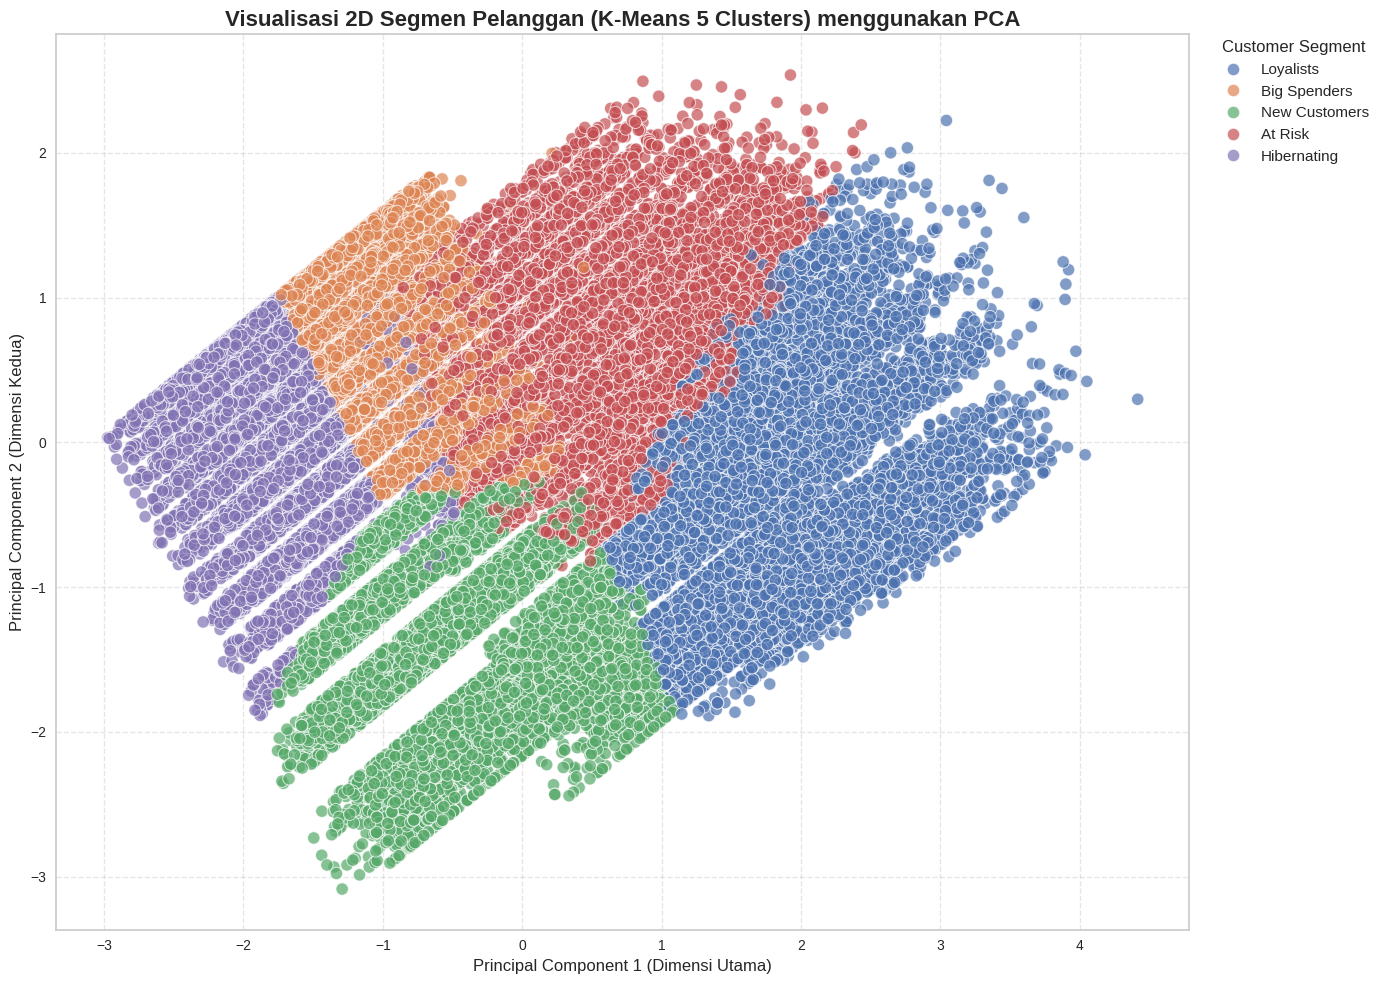

In [ ]:
# --- TAHAP 1: PENERAPAN PCA ---
print("Sedang melakukan reduksi dimensi dengan PCA...")
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled_df)
df_pca = pd.DataFrame(data=pca_components, columns=['PC1 (Principal Component 1)', 'PC2 (Principal Component 2)'])
df_pca['Customer_Segment'] = df_rfm['Customer_Segment'].values

print("\n--- Sample Data setelah PCA (Siap Visualisasi) ---")
display(df_pca.head())


# --- TAHAP 2: EVALUASI INFORMASI PCA ---
# 'Explained Variance Ratio' menunjukkan berapa persen informasi yang ditangkap tiap komponen.
variance_ratio = pca.explained_variance_ratio_
total_variance = sum(variance_ratio) * 100

print(f"\nExplained Variance Ratio per Komponen: {variance_ratio}")
print(f"Total Informasi yang Terjaga dalam Visualisasi 2D ini: {total_variance:.2f}%")
# Insight: Jika Total > 80%, visualisasi ini sangat representatif dan bisa dipercaya.


# --- TAHAP 3: VISUALISASI 2D SCATTER PLOT ---
plt.figure(figsize=(14, 10))
# Mengatur urutan legenda agar rapi (opsional, sesuaikan dengan preferensi Anda)
# Misalnya diurutkan dari yang paling 'bagus' ke paling 'buruk'
hue_order = ['Loyalists', 'Big Spenders', 'New Customers', 'At Risk', 'Hibernating']
# Filter hue_order hanya untuk segmen yang benar-benar ada di data saat ini
existing_segments = [seg for seg in hue_order if seg in df_pca['Customer_Segment'].unique()]

sns.scatterplot(
    x='PC1 (Principal Component 1)',
    y='PC2 (Principal Component 2)',
    hue='Customer_Segment', # Warna dibedakan berdasarkan segmen
    data=df_pca,
    palette='deep',         # Pilihan palet warna: 'deep', 'viridis', 'Set1', dll.
    hue_order=existing_segments, # Memastikan urutan legenda konsisten
    s=80,                   # Ukuran titik
    alpha=0.7,              # Transparansi (agar terlihat jika ada titik menumpuk)
    edgecolor='w'           # Garis putih tipis di pinggir titik agar lebih tegas
)

plt.title('Visualisasi 2D Segmen Pelanggan (K-Means 5 Clusters) menggunakan PCA', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1 (Dimensi Utama)', fontsize=12)
plt.ylabel('Principal Component 2 (Dimensi Kedua)', fontsize=12)

plt.legend(title='Customer Segment', title_fontsize=12, fontsize=11,
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Gabungin dataframe jadi satu

In [ ]:
df_final = pd.concat([
    df_temp.reset_index(drop=True),
    df_rfm.reset_index(drop=True),
    df_pca.reset_index(drop=True)
], axis=1)

# 1. Hapus kolom duplikat (kita hanya simpan satu kolom 'Customer_Segment')
df_final = df_final.loc[:, ~df_final.columns.duplicated()]

# 2. Cek apakah sekarang sudah benar (Harusnya hanya muncul 1 kali)
print("Daftar Kolom saat ini:", df_final.columns.tolist())

df_final.head(10)

,order_status,age,gender,income,product_category,products,payment_method,quantity,unit_price,Recency,Frequency,Monetary,Cluster,Customer_Segment,PC1 (Principal Component 1),PC2 (Principal Component 2),Customer_Segment
0,Shipped,21.0,Male,Low,Clothing,Cycling shorts,Debit Card,3.0,108.028757,103.0,3.0,2324.509346,0.0,At Risk,1.040306,0.214545,At Risk
1,Shipped,64.0,Female,Low,Home Decor,Screwdriver set,Credit Card,4.0,90.981870,105.0,4.0,4256.918342,2.0,Loyalists,1.731307,0.656822,Loyalists
2,Shipped,32.0,Female,High,Clothing,V-neck tee,Cash,6.0,297.726039,95.0,4.0,3747.140929,2.0,Loyalists,1.674287,0.483393,Loyalists
3,Shipped,19.0,Female,High,Electronics,Samsung Galaxy Tab,Cash,3.0,139.786855,228.0,1.0,1890.735874,4.0,Big Spenders,-1.058516,0.609561,Big Spenders
4,Shipped,69.0,Male,Low,Home Decor,Bookshelf,Cash,2.0,469.659639,246.0,1.0,3073.147975,4.0,Big Spenders,-0.774759,0.979994,Big Spenders
5,Delivered,43.0,Male,Medium,Home Decor,Curtains,Cash,8.0,333.859664,16.0,1.0,3383.222304,3.0,New Customers,0.430180,-1.087945,New Customers
6,Delivered,58.0,Female,High,Clothing,Bodycon dress,Cash,3.0,312.976573,34.0,3.0,6239.019428,2.0,Loyalists,2.267304,0.055546,Loyalists
7,Delivered,35.0,Female,Medium,Home Decor,Comforter,Credit Card,7.0,346.719593,122.0,1.0,49.274554,1.0,Hibernating,-2.025080,-1.181935,Hibernating
8,Delivered,59.0,Male,High,Electronics,Android TV,PayPal,2.0,281.600169,61.0,3.0,2014.622972,2.0,Loyalists,1.170918,-0.287503,Loyalists
9,Shipped,46.0,Male,Low,Clothing,Sneakers,Debit Card,4.0,129.756972,292.0,1.0,638.851449,1.0,Hibernating,-1.833899,0.507058,Hibernating


In [ ]:
# Cek Distribusi Global (Seluruh Data)
print("--- STATISTIK GLOBAL (SEMUA DATA) ---")
print(df_final['gender'].value_counts(normalize=True) * 100)
print("\n")
print(df_final['income'].value_counts(normalize=True) * 100)
print("\n")
print(df_final['age'].value_counts(normalize=True) * 100)

=== Grafik Produk Paling Dibeli per Cluster ===

--- Cluster 0 ---


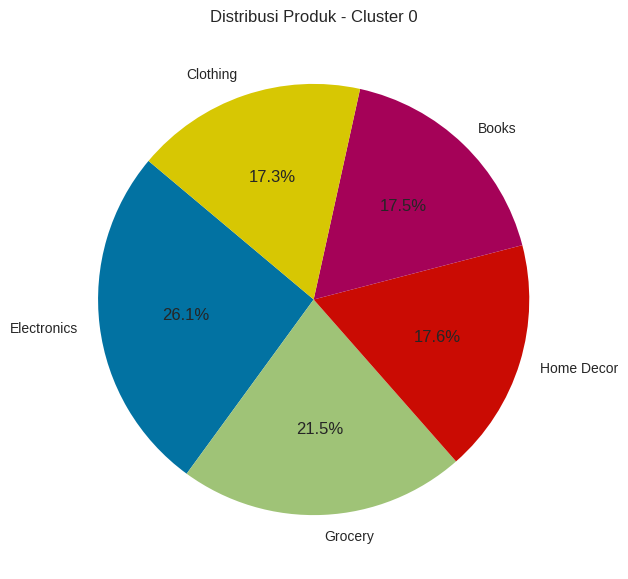


--- Cluster 1 ---


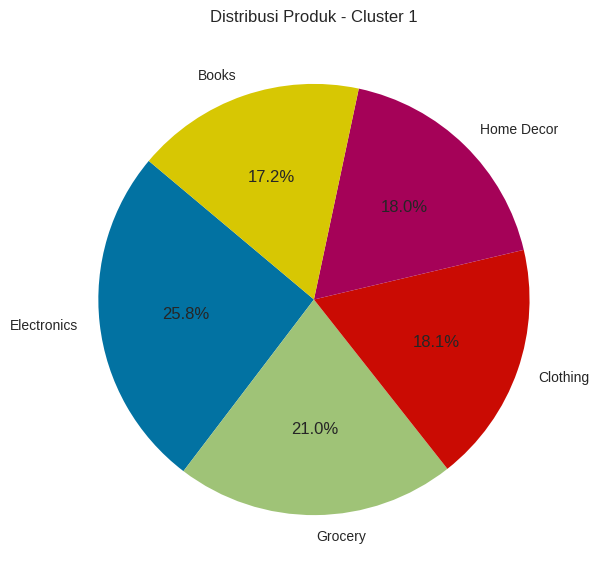


--- Cluster 2 ---


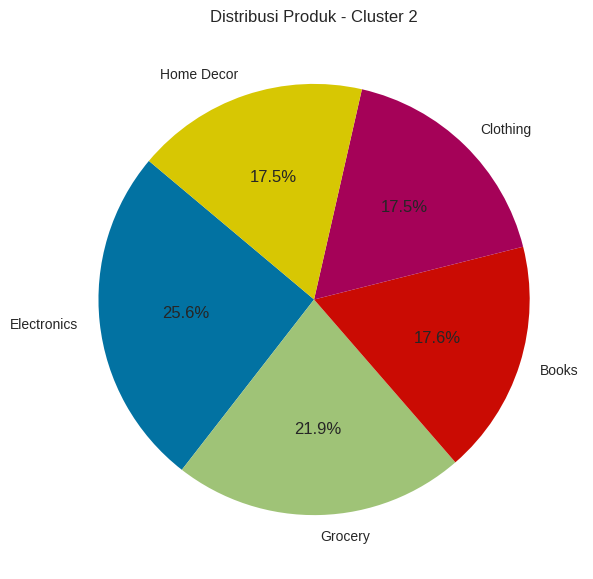


--- Cluster 3 ---


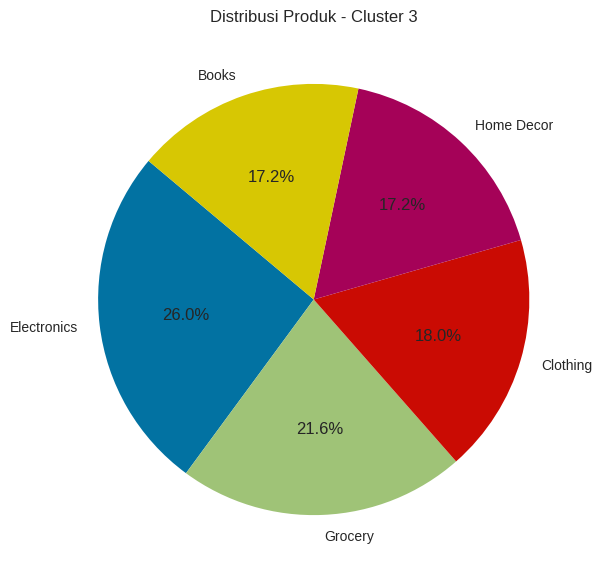


--- Cluster 4 ---


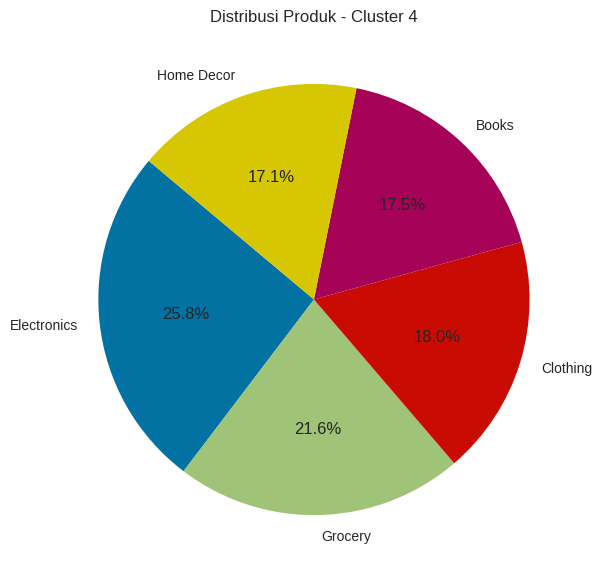

In [ ]:
def visualisasi_terpisah_per_cluster_fixed(df_final, df_transaksi_asli):
    # 1. PERSIAPAN DATA HYBRID
    # A. Data untuk Bar Chart (Butuh History Transaksi Lengkap)
    #    Kita merge segment dari df_final ke df_transaksi_asli
    #    Pastikan df_final punya 'customer_id' sebagai kolom
    if 'customer_id' not in df_final.columns: df_final = df_final.reset_index()

    df_lengkap = df_transaksi_asli.merge(df_final[['customer_id', 'Customer_Segment']],
                                         on='customer_id', how='left')

    # B. Urutan Segmen
    urutan_segmen = ['Loyalists', 'Big Spenders', 'New Customers', 'At Risk', 'Hibernating']
    segmen_tersedia = [s for s in urutan_segmen if s in df_final['Customer_Segment'].unique()]

    # Set Style
    sns.set_style("whitegrid")

    for segmen in segmen_tersedia:
        # Filter Data
        # Data Transaksi (Banyak baris per user) -> Untuk Kategori Produk
        data_produk = df_lengkap[df_lengkap['Customer_Segment'] == segmen]

        # Data Unik (Satu baris per user) -> Untuk Scatter Plot RFM
        data_rfm = df_final[df_final['Customer_Segment'] == segmen]

        print("\n" + "="*80)
        print(f" >>> VISUALISASI CLUSTER: {segmen.upper()} <<<")
        print("="*80 + "\n")

        # ==============================================================================
        # GRAFIK 1: TOP 5 KATEGORI PRODUK (Bar Chart) -> SUMBER: DATA TRANSAKSI
        # ==============================================================================
        plt.figure(figsize=(10, 6))

        # Gunakan 'product_category' (lowercase) sesuai dataframe asli
        col_prod = 'product_category' if 'product_category' in data_produk.columns else 'Product_Category'

        if col_prod in data_produk.columns:
            # Hitung frekuensi dari data transaksi lengkap
            top_cat = data_produk[col_prod].value_counts().head(5)

            ax = sns.barplot(x=top_cat.values, y=top_cat.index, palette='viridis')

            plt.title(f'Top 5 Kategori Favorit - {segmen}', fontsize=16, fontweight='bold', pad=20)
            plt.xlabel('Total Item Terjual (Frequency)', fontsize=12)
            plt.ylabel('Kategori Produk', fontsize=12)

            for i, v in enumerate(top_cat.values):
                ax.text(v + 0.5, i, str(v), color='black', va='center', fontweight='bold')
        else:
            plt.text(0.5, 0.5, 'Kolom Kategori Tidak Ditemukan di Data Transaksi', ha='center')

        plt.tight_layout()
        plt.show()

        # ==============================================================================
        # GRAFIK 2: POLA BELANJA (Scatter Plot) -> SUMBER: DATA UNIK (RFM)
        # ==============================================================================
        plt.figure(figsize=(10, 6))

        # Gunakan Recency & Monetary dari df_final (Data Unik)
        # Tidak perlu drop_duplicates lagi karena df_final diasumsikan sudah unik per customer
        sns.scatterplot(data=data_rfm, x='Recency', y='Monetary',
                        color='#FF6F61', alpha=0.7, s=80, edgecolor='black')

        plt.title(f'Pola Belanja (Recency vs Monetary) - {segmen}', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Recency (Hari sejak pembelian terakhir)', fontsize=12)
        plt.ylabel('Monetary (Total Belanja)', fontsize=12)

        # Garis Rata-rata
        avg_r = data_rfm['Recency'].mean()
        avg_m = data_rfm['Monetary'].mean()
        plt.axvline(avg_r, color='blue', linestyle='--', label=f'Rata-rata Recency: {avg_r:.0f} hari')
        plt.axhline(avg_m, color='green', linestyle='--', label=f'Rata-rata Monetary: {avg_m:,.0f}')
        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

# --- EKSEKUSI ---
# Masukkan DUA Dataframe:
# 1. df_final (Data Unik hasil Clustering)
# 2. df (Data Transaksi Asli dari awal load csv)
visualisasi_terpisah_per_cluster_fixed(df_final, df)

In [ ]:
rfm_summary = df_final.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# 3. Menambahkan kolom jumlah user per cluster (Opsional tapi sangat berguna)
rfm_summary['Count'] = df_final.groupby('Cluster')['customer_id'].count().values

# 4. Membulatkan angka agar tabel mudah dibaca
rfm_summary = rfm_summary.round(2)

print("Tabel Rata-rata RFM per Cluster:")
display(rfm_summary)

In [ ]:
# SEGMENT PER CLUSTER + MARKETING STRATEGIES (Otomatis)

print("\nMembangun segmentasi pelanggan dan strategi pemasaran ")

# Ringkasan profil cluster
cluster_profile = df_rfm.groupby('Customer_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Tambahkan nomor cluster
cluster_profile = cluster_profile.sort_values('Customer_Segment').reset_index(drop=True)
cluster_profile['Cluster_Number'] = cluster_profile.index + 1


# === Fungsi pemberian nama segmen ===
def assign_segment_label(r, q_rec, q_freq, q_mon):

    high_freq = r['Frequency'] >= q_freq[0.75]
    med_freq  = r['Frequency'] >= q_freq[0.50]

    high_mon = r['Monetary'] >= q_mon[0.75]
    med_mon  = r['Monetary'] >= q_mon[0.50]

    low_rec = r['Recency'] <= q_rec[0.25]
    med_rec = r['Recency'] <= q_rec[0.50]

    # === Rule-based segmentation ===
    if low_rec and high_freq and high_mon:
        return "Loyalist"
    if low_rec and med_freq:
        return "New Customers"
    if med_rec and med_freq and med_mon:
        return "At-Risk"
    if high_mon and not high_freq:
        return "High Spend Occasional Buyers"
    if r['Recency'] > q_rec[0.75] and r['Frequency'] < q_freq[0.50]:
        return "Hibernating"
    if r['Frequency'] < q_freq[0.25]:
        return "Big Spender"

    return "General Customers"


# Kuartil
q_rec = cluster_profile['Recency'].quantile([0.25, 0.50, 0.75])
q_freq = cluster_profile['Frequency'].quantile([0.25, 0.50, 0.75])
q_mon = cluster_profile['Monetary'].quantile([0.25, 0.50, 0.75])


# === Fungsi strategi pemasaran otomatis ===
def marketing_strategy(segment):

    strategies = {
        "Loyalist": [
            "Berikan rewards eksklusif atau program VIP.",
            "Prioritaskan early access untuk produk baru.",
            "Gunakan komunikasi personal untuk menjaga loyalitas.",
        ],
        "New Customers": [
            "Dorong pembelian ulang melalui voucher follow-up.",
            "Rekomendasikan produk sesuai riwayat belanja terakhir.",
            "Gunakan email welcome series dengan penawaran menarik."
        ],
        "At-Risk": [
            "Gunakan promo mass-market harga rendah.",
            "Berikan free shipping untuk meningkatkan kunjungan.",
            "Optimalkan ads awareness dan broad campaign."
        ],
        "High Spend Occasional Buyers": [
            "Gunakan kampanye premium dan bundling produk.",
            "Promosikan produk bernilai tinggi.",
            "Dorong kunjungan lebih sering dengan bonus poin."
        ],
        "Hibernating": [
            "Gunakan diskon reaktivasi yang agresif.",
            "Kirim notifikasi personal mengenai produk favorit mereka.",
            "A/B testing email reminder untuk menarik kembali pelanggan."
        ],
        "Big Spender": [
            "Gunakan kampanye premium dan bundling produk.",
            "Promosikan produk bernilai tinggi.",
            "Dorong kunjungan lebih sering dengan bonus poin."

        ],
        "General Customers": [
            "Gunakan kampanye standar dengan personalisasi ringan.",
            "Berikan rekomendasi produk populer.",
            "Perkuat engagement melalui konten sosial."
        ]
    }

    return strategies.get(segment, ["Tidak ada strategi spesifik."])


# Tambahkan label segmen & strategi
cluster_profile['Segment_Label'] = cluster_profile.apply(
    lambda r: assign_segment_label(r, q_rec, q_freq, q_mon),
    axis=1
)
cluster_profile['Marketing_Strategies'] = cluster_profile['Segment_Label'].apply(marketing_strategy)



# EDA: Produk Paling Sering Dibeli per Cluster
df_merged = df.merge(
    df_rfm[['customer_id', 'Cluster', 'Customer_Segment']],
    on='customer_id',
    how='left'
)

# Cek missing cluster
df_merged['Cluster'] = df_merged['Cluster'].fillna(-1)

# Produk populer per cluster
top_products_per_cluster = (
    df_merged.groupby(['Cluster', 'product_category'])
    .size()
    .reset_index(name='Count')
    .sort_values(['Cluster', 'Count'], ascending=[True, False])
)

# Ambil top 3 produk tiap cluster
top3 = top_products_per_cluster.groupby('Cluster').head(3)


# Masukkan EDA produk ke cluster_profile
eda_dict = {}
for cluster, grp in top3.groupby('Cluster'):
    eda_dict[cluster] = grp[['product_category', 'Count']].to_dict(orient='records')

cluster_profile['Top_Products'] = cluster_profile['Cluster_Number'].map(
    lambda num: eda_dict.get(num-1, [])
)

# Integrasi EDA ke dalam strategi pemasaran
def enhance_strategy_with_products(strategy_list, products):
    if not products:
        return strategy_list

    top_items = ", ".join([p['product_category'] for p in products])
    extra = f"Fokus pada promosi produk yang paling sering dibeli: {top_items}."
    return strategy_list + [extra]

cluster_profile['Enhanced_Strategy'] = cluster_profile.apply(
    lambda r: enhance_strategy_with_products(
        r['Marketing_Strategies'], r['Top_Products']
    ),
    axis=1
)

# Output Final
print("\n=== Segment, EDA & Strategy per Cluster ===")
for _, row in cluster_profile.iterrows():
    print(f"\nCluster {row['Cluster_Number']} ({row['Customer_Segment']})")
    print(f"- Segment : {row['Segment_Label']}")
    print(f"- Recency  : {row['Recency']:.2f}")
    print(f"- Frequency: {row['Frequency']:.2f}")
    print(f"- Monetary : {row['Monetary']:.2f}")

    print("- Top Produk yang Sering Dibeli:")
    for p in row['Top_Products']:
        print(f"  • {p['product_category']}")

    print("- Marketing Strategy (Termasuk EDA):")
    for s in row['Enhanced_Strategy']:
        print(f"  • {s}")


Membangun segmentasi pelanggan dan strategi pemasaran 

=== Segment, EDA & Strategy per Cluster ===

Cluster 1 (At Risk)
- Segment : At-Risk
- Recency  : 166.37
- Frequency: 2.28
- Monetary : 2938.45
- Top Produk yang Sering Dibeli:
  • Electronics
  • Grocery
  • Home Decor
- Marketing Strategy (Termasuk EDA):
  • Gunakan promo mass-market harga rendah.
  • Berikan free shipping untuk meningkatkan kunjungan.
  • Optimalkan ads awareness dan broad campaign.
  • Fokus pada promosi produk yang paling sering dibeli: Electronics, Grocery, Home Decor.

Cluster 2 (Big Spenders)
- Segment : Big Spender
- Recency  : 225.75
- Frequency: 1.00
- Monetary : 2342.64
- Top Produk yang Sering Dibeli:
  • Electronics
  • Grocery
  • Clothing
- Marketing Strategy (Termasuk EDA):
  • Gunakan kampanye premium dan bundling produk.
  • Promosikan produk bernilai tinggi.
  • Dorong kunjungan lebih sering dengan bonus poin.
  • Fokus pada promosi produk yang paling sering dibeli: Electronics, Grocery, Cloth

In [ ]:
!pip install pipreqs

In [ ]:
!pipreqs . --force --savepath requirements.txt

# --- Tampilkan Hasil ---
print("\n--- Isi requirements.txt ---")
!cat requirements.txt